# Imports

In [ ]:
import os
from pathlib import Path
from functools import partial
from typing import List, Optional, Union
import json

from tqdm import tqdm
import einops
import math
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from neel_plotly import line, imshow, scatter # pip install git+https://github.com/neelnanda-io/neel-plotly.git
import torch
from torch import Tensor
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float
from typing import List, Optional, Tuple, Dict, Literal, Set
from rich.table import Table, Column
from rich import print as rprint
import matplotlib.pyplot as plt
import seaborn as sns


import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

update_layout_set = {"xaxis_range", "yaxis_range", "yaxis2_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "xaxis_tickangle"}
from transformer_lens.utils import to_numpy

def bar(tensor, renderer=None, **kwargs):
    '''
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    px.bar(y=to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

# Automatically reload scripts that are modified outside of the notebook
%load_ext autoreload
%autoreload 2

Disabled automatic differentiation


# Applying RoPE Simulation

RoPE is a positional encoding mechanism introduced in [RoFormer](https://arxiv.org/pdf/2104.09864) and widely adopted in modern LLMs. The following is a simulation of applying RoPE encoding to Q/K/V before computing the attention scores. This will use the Transformer Lens implementation, but with intermediate visualizations of what is happening. The next section will try to see how the query and key vectors behave before and after applying RoPE in a forward pass with Llama 3.2-1B.

First, we need to declare the three functions from the `AbstractAttention` class which can be found in `transformerlens.components.abstract_attention`.

In [98]:
import torch
import einops
from transformer_lens.utils import get_offset_position_ids

class RotaryEmbeddingSimulator:
    def __init__(self, cfg):
        self.cfg = cfg
        # Precompute sine and cosine matrices for rotary embeddings.
        self.rotary_sin, self.rotary_cos = self.calculate_sin_cos_rotary(
            rotary_dim=cfg.rotary_dim, # 64 = d_head
            n_ctx=cfg.n_ctx, # 2048
            base=cfg.rotary_base, # 10000 base frequency for rotary, used also in Attention is All you need for sinusoidal positional encoding
            dtype=torch.float32,
        )

    def calculate_sin_cos_rotary(self, rotary_dim: int, n_ctx: int, base: int = 10000, dtype: torch.dtype = torch.float32):
        """
        Compute sine and cosine matrices for rotary embeddings.
        """
        high_precision = torch.float32 if dtype != torch.float64 else torch.float64
        pos = torch.arange(n_ctx, dtype=high_precision)
        dim = torch.arange(rotary_dim // 2, dtype=high_precision)
        # Frequencies spaced in log space.
        freq = base ** (dim / (rotary_dim / 2))
        if self.cfg.rotary_adjacent_pairs:
            # GPT-J style: adjacent pairs rotated.
            freq = einops.repeat(freq, "d -> (d 2)")
        else:
            # GPT-NeoX style.
            freq = einops.repeat(freq, "d -> (2 d)")
        # Create angles for each position and frequency.
        angles = pos[:, None] / freq[None, :]
        return torch.sin(angles).to(dtype), torch.cos(angles).to(dtype)

    def rotate_every_two(self, x: torch.Tensor) -> torch.Tensor:
        """
        For each adjacent pair in the last dimension of x, map [x0, x1] to [-x1, x0].
        """
        rot_x = x.clone()
        if self.cfg.rotary_adjacent_pairs:
            rot_x[..., ::2] = -x[..., 1::2]
            rot_x[..., 1::2] = x[..., ::2]
        else:
            n = x.size(-1) // 2
            rot_x[..., :n] = -x[..., n:]
            rot_x[..., n:] = x[..., :n]
        return rot_x

    def apply_rotary(self, x: torch.Tensor, past_kv_pos_offset: int = 0, attention_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Apply rotary embeddings to the first rotary_dim dimensions of x.
        x should have shape [batch, pos, head_index, d_head].
        """
        x_pos = x.size(1)
        # Split x into the rotary part and the pass-through part.
        x_rot = x[..., :self.cfg.rotary_dim]      # dimensions to be rotated
        x_pass = x[..., self.cfg.rotary_dim :]      # remaining dimensions
        # Compute the "rotated" version of x_rot.
        x_flip = self.rotate_every_two(x_rot)

        if attention_mask is None:
            # Select the appropriate slices of the precomputed rotary sin/cos.
            rotary_cos = self.rotary_cos[None, past_kv_pos_offset: past_kv_pos_offset + x_pos, None, :]
            rotary_sin = self.rotary_sin[None, past_kv_pos_offset: past_kv_pos_offset + x_pos, None, :]
            x_rotated = x_rot * rotary_cos + x_flip * rotary_sin
        else:
            # If you have an attention mask, you might want to compute offset position ids.
            # get_offset_position_ids is a helper function that returns indices of non-padded tokens, offset by the position of the first attended token, useful when computing the attention 
            offset_position_ids = get_offset_position_ids(past_kv_pos_offset, attention_mask) 
            offset_position_ids = offset_position_ids.to(self.rotary_cos.device)
            mask_rotary_cos = self.rotary_cos[offset_position_ids, None, :]
            mask_rotary_sin = self.rotary_sin[offset_position_ids, None, :]
            x_rotated = x_rot * mask_rotary_cos + x_flip * mask_rotary_sin

        # Concatenate the rotated and pass-through parts.
        return torch.cat([x_rotated, x_pass], dim=-1)


# Example usage of the RotaryEmbeddingSimulator. 
# Create a dummy config object with the needed attributes.
class DummyConfig:
    pass

cfg = DummyConfig()
cfg.rotary_dim = 64            # e.g., apply rotary to first 64 dims
cfg.n_ctx = 2048               # maximum sequence length
cfg.rotary_base = 10000        # base frequency for rotary
cfg.rotary_adjacent_pairs = True
cfg.positional_embedding_type = "rotary"

# Instantiate the rotary embedding simulator.
rotary_sim = RotaryEmbeddingSimulator(cfg)

# Simulate some query, key, and value vectors.
# For simplicity, use a single batch.
batch = 1
pos = 128
n_heads = 32
d_head = 64

q = torch.randn(batch, pos, n_heads, d_head)
k = torch.randn(batch, pos, n_heads, d_head)
v = torch.randn(batch, pos, n_heads, d_head)  # Typically v is not rotated

# If the model uses rotary embeddings, apply them.
if cfg.positional_embedding_type == "rotary":
    # Usually, rotary is applied to q and k.
    q_rot = rotary_sim.apply_rotary(q, past_kv_pos_offset=0, attention_mask=None)
    k_rot = rotary_sim.apply_rotary(k, past_kv_pos_offset=0, attention_mask=None)
    # Optionally, you can also apply rotary to v if desired.
    v_rot = rotary_sim.apply_rotary(v, past_kv_pos_offset=0, attention_mask=None)
else:
    q_rot, k_rot, v_rot = q, k, v

# q_rot and k_rot now contain the rotary-embedded vectors,
# which you would then use in the attention computation.
print("q_rot shape:", q_rot.shape)
print("k_rot shape:", k_rot.shape)
print("v_rot shape:", v_rot.shape)

q_rot shape: torch.Size([1, 128, 32, 64])
k_rot shape: torch.Size([1, 128, 32, 64])
v_rot shape: torch.Size([1, 128, 32, 64])


## Data and Setup 

In [99]:
rotary_dim = 8   # For demo, keep small so it's easy to visualize
d_head = 32      # Example total head dimension
pos = 20         # Number of tokens (sequence length)
base = 10000

# Create a dummy query tensor q of shape [pos, d_head].
# (In a real model, q would be [batch, pos, head_index, d_head].)
q = torch.randn(pos, d_head)

# We'll define minimal sin/cos arrays for the first 'pos' positions,
# shaped [pos, rotary_dim].
positions = torch.arange(pos, dtype=torch.float32).unsqueeze(1)  # (pos, 1)
dim = torch.arange(rotary_dim // 2, dtype=torch.float32)         # (rotary_dim/2,)

# Frequencies spaced in log space
freq = base ** (dim / (rotary_dim / 2))
# For simplicity, assume GPT-J style (adjacent pairs)
freq = einops.repeat(freq, "d -> (d 2)")
angles = positions / freq[None, :]  # shape (pos, rotary_dim)

rotary_sin = torch.sin(angles)  # (pos, rotary_dim)
rotary_cos = torch.cos(angles)  # (pos, rotary_dim)

## Split q into x_rot and x_pass

In [100]:
x_rot = q[:, :rotary_dim]        # shape (pos, rotary_dim)
x_pass = q[:, rotary_dim:]       # shape (pos, d_head - rotary_dim)

## Apply the rotation to x_rotated

In [101]:
def rotate_every_two(x: torch.Tensor) -> torch.Tensor:
    """
    In GPT-J style, for each adjacent pair [x0, x1], map to [-x1, x0].
    x shape: (..., rotary_dim) with rotary_dim even.
    """
    x_rot = x.clone()
    # Since we're using 'adjacent pairs', do x[..., ::2] -> -x[..., 1::2], etc.
    x_rot[..., ::2] = -x[..., 1::2]
    x_rot[..., 1::2] = x[..., ::2]
    return x_rot

# For each token position i, we multiply x_rot[i] by rotary_cos[i]
# and rotate_every_two(x_rot[i]) by rotary_sin[i].
x_flip = rotate_every_two(x_rot)  # shape (pos, rotary_dim)

# Expand cos, sin to match shape (pos, rotary_dim)
# Already shape: (pos, rotary_dim)
# So we can do elementwise multiplication
x_rotated = x_rot * rotary_cos + x_flip * rotary_sin

## Concatenate x_rotated with x_pass

In [104]:
q_rot = torch.cat([x_rotated, x_pass], dim=-1)  # shape: (pos, d_head)

# Optional assertion to check that x_pass os unchanged in q_rot.

# Compare the pass-through portion:
pass_portion_original = x_pass
pass_portion_rotary   = q_rot[:, rotary_dim:]  # the "tail" of q_rot

difference = (pass_portion_original - pass_portion_rotary).abs().max()
print("Max difference in pass-through portion:", difference.item()) # Should be ~0.0, indicating it's unchanged.

Max difference in pass-through portion: 0.0


## Visualize the rotation in 2D

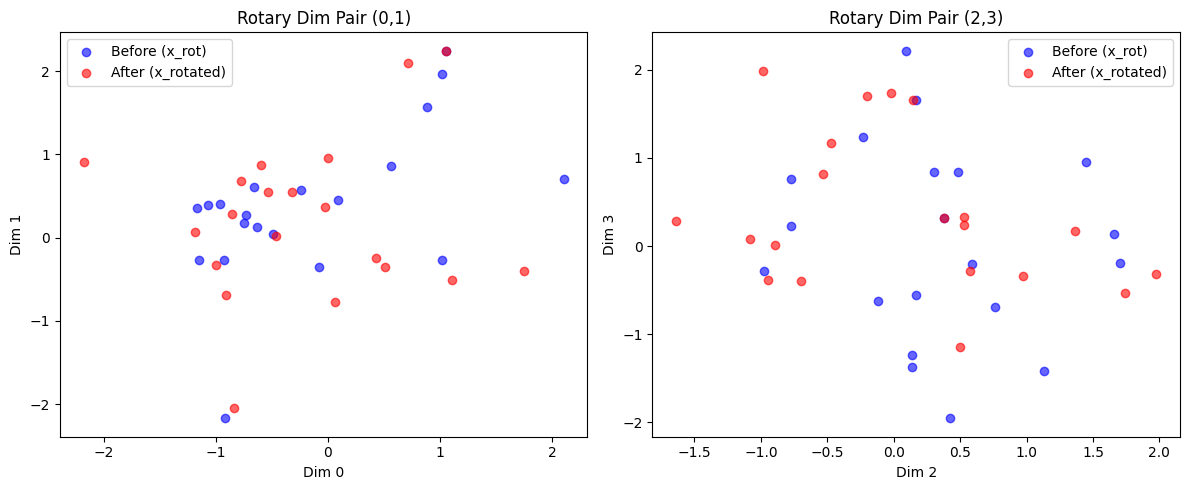

In [103]:
# We'll pick dimension pairs from [0..rotary_dim).
# For example, (0,1), (2,3) if rotary_dim=8
dim_pairs = [(0,1), (2,3)]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax_idx, (d1, d2) in enumerate(dim_pairs):
    ax = axes[ax_idx]
    # Plot x_rot
    ax.scatter(x_rot[:, d1], x_rot[:, d2], c='blue', label='Before (x_rot)', alpha=0.6)
    # Plot x_rotated
    ax.scatter(x_rotated[:, d1], x_rotated[:, d2], c='red', label='After (x_rotated)', alpha=0.6)

    ax.set_xlabel(f"Dim {d1}")
    ax.set_ylabel(f"Dim {d2}")
    ax.set_title(f"Rotary Dim Pair ({d1},{d2})")
    ax.legend()

plt.tight_layout()
plt.show()


In [138]:
import torch
import numpy as np
import plotly.graph_objects as go

# --- Setup ---
pos = 20         # number of tokens
d_head = 8       # total head dimension
rotary_dim = 4   # dimensions to receive rotary embedding (for demo, keep small)
base = 10000

# Create a dummy query tensor q of shape (pos, d_head)
q = torch.randn(pos, d_head)

# Split q into the rotary part and the pass-through part
x_rot = q[:, :rotary_dim]   # shape: (20, rotary_dim)
x_pass = q[:, rotary_dim:]  # shape: (20, d_head - rotary_dim)

# For simplicity, we visualize only the first two rotary dimensions.
x_2d = x_rot[:, :2]         # shape: (20, 2)

# Create a 1D angles tensor (one angle per token)
# For demo purposes, we use token index as the base angle.
angles = torch.arange(pos, dtype=torch.float32)  # shape: (20,)

# --- Helper function for partial rotation ---
def partial_rotate_2d(x_2d: torch.Tensor, angles: torch.Tensor, alpha: float) -> torch.Tensor:
    """
    Rotates each token's (x, y) coordinate by alpha * angle.
    
    x_2d: Tensor of shape (pos, 2)
    angles: Tensor of shape (pos,) -- one angle per token.
    alpha: scalar between 0 and 1.
    
    Returns: Tensor of shape (pos, 2)
    """
    pos = x_2d.shape[0]
    x_2d_rot = x_2d.clone()
    for i in range(pos):
        # IMPORTANT: index angles with one index since it's 1D.
        theta = alpha * angles[i].item()
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)
        x, y = x_2d_rot[i, 0].item(), x_2d_rot[i, 1].item()
        # Standard 2D rotation:
        x_new = x * cos_t - y * sin_t
        y_new = x * sin_t + y * cos_t
        x_2d_rot[i, 0] = x_new
        x_2d_rot[i, 1] = y_new
    return x_2d_rot

# Compute the final (full) rotated positions (alpha=1) for the "After" state.
x_2d_after = partial_rotate_2d(x_2d, angles, alpha=1.0).detach().numpy()
# "Before" is just x_2d as-is.
x_2d_before = x_2d.detach().numpy()

# --- Generate Animation Frames ---
Nframes = 50
frames = []
for frame in range(Nframes+1):
    alpha = frame / Nframes
    rotated = partial_rotate_2d(x_2d, angles, alpha).detach().numpy()
    frames.append(
    go.Frame(
        data=[go.Scatter(
            x=rotated[:, 0],
            y=rotated[:, 1],
            mode='markers',
            marker=dict(color='red', size=10),
            name='Rotating',
            showlegend=False  # Disable legend entry in frames
        )],
        name=f'frame{frame}'
    )
)

# --- Create Base Figure ---
# Initial frame (alpha = 0)
initial_rotated = partial_rotate_2d(x_2d, angles, alpha=0).detach().numpy()

fig = go.Figure(
    data=[
        # Static "Before" positions (blue)
        go.Scatter(x=x_2d_before[:, 0],
                   y=x_2d_before[:, 1],
                   mode='markers',
                   marker=dict(color='blue', size=10),
                   name='Before'),
        # Static "After" positions (green)
        go.Scatter(x=x_2d_after[:, 0],
                   y=x_2d_after[:, 1],
                   mode='markers',
                   marker=dict(color='green', size=10),
                   name='After'),
        # "Rotating" positions (red) will be animated
        go.Scatter(x=initial_rotated[:, 0],
                   y=initial_rotated[:, 1],
                   mode='markers',
                   marker=dict(color='red', size=10),
                   name='Rotating')
    ],
    frames=frames
)

# --- Layout with Animation Controls ---
# Determine axis ranges from the "Before" and "After" data
x_vals = np.concatenate([x_2d_before[:, 0], x_2d_after[:, 0]])
y_vals = np.concatenate([x_2d_before[:, 1], x_2d_after[:, 1]])

fig.update_layout(
    title="RoPE Animation (Simplified 2D) using Plotly",
    xaxis=dict(range=[x_vals.min()-1, x_vals.max()+1]),
    yaxis=dict(range=[y_vals.min()-1, y_vals.max()+1]),
    updatemenus=[{
        "type": "buttons",
        "buttons": [{
            "label": "Play",
            "method": "animate",
            "args": [None, {"frame": {"duration": 100, "redraw": True},
                            "fromcurrent": True}]
        }]
    }]
)

fig.show()

# Model Loading

The various flags are simplifications that preserve the model's output but simplify its internals:

In [2]:
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-3.2-1B",   
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
)                              

device: torch.device = utils.get_device()

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


# Import Dataset and Setup 

In [3]:
from data.homonymy_dataset import Dataset

dataset = Dataset(file_path="data/homonymy_dataset.json", model=model, tokenizer=None, device=device)

all_prompts = dataset.all_prompts # pairs of clean and corr prompts
all_prompts_strings = dataset.all_prompts_strings # concatenated clean and corr prompts
all_answers = dataset.all_answer_strings # concatenated clean and corr answers
all_tokens = dataset.all_token_ids

all_answer_tok_ids = dataset.all_answer_tok_ids
clean_prompts = dataset.clean_prompts
clean_answers_tok_ids = dataset.clean_answer_tok_ids
corr_prompts = dataset.corr_prompts
corr_answers_tok_ids = dataset.corr_answer_tok_ids

/home/iustin/.conda/envs/tlens/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Forward pass

Forward pass to get logits and activation cache dictionary:

In [90]:
all_logits, all_cache = model.run_with_cache(all_tokens)

Iterate through the cached dictionary and print all saved activations and their shape:

Retrieve the `attn.hook_rot_q` and `attn.hook_rot_k` activations that serve as input to [GQA](https://arxiv.org/pdf/2305.13245) (Grouped Query Attention):

More information about how `hook_rot_q` and `hook_rot_k` are computed and their shapes in: 
1. `transformer_lens.components.abstract_attention` : functions for computing RoPE
2. `transformer_lens.components.grouped_query_attention`: apply RoPE in GQA Attention: 

    -  query_input (Union[Float[torch.Tensor, "batch pos d_model"], `Float[torch.Tensor, "batch pos head_index d_model"]]`): The input tensor for the query projection.
    - key_input (Union[Float[torch.Tensor, "batch pos d_model"], `Float[torch.Tensor, "batch pos kv_head_index d_model"]]`): The input tensor for the key projection. Note that is has as many **head dimensions as the GPA block has key-value heads**.
    - value_input (Union[Float[torch.Tensor, "batch pos d_model"], `Float[torch.Tensor, "batch pos kv_head_index d_model"]]`): The input tensor for the value projection. Note that is has as many **head dimensions as the GPA block has key-value heads**.

The `key-value heads` parameter is used to define the GQA group number, i.e. the subgroup of query heads that share a single key head and value head.

In [ ]:
rot_act_q = utils.get_act_name('rot_q', '0', 'a')
rot_act_k = utils.get_act_name('rot_k', '0', 'a')

pre_rot_q = utils.get_act_name('q', '0', 'a')
pre_rot_k = utils.get_act_name('k', '0', 'a')

rot_act_q_cached = all_cache[rot_act_q]
rot_act_k_cached = all_cache[rot_act_k]

pre_rot_q_cached = all_cache[pre_rot_q]
pre_rot_k_cached = all_cache[pre_rot_k]

embed_cached = all_cache['hook_embed']

print("Shape of rot_act_q_cached:", rot_act_q_cached.shape) # (bsz, seq_len, n_heads, head_dim)
print("Shape of rot_act_k_cached:", rot_act_k_cached.shape) # (bsz, seq_len, kv_head_index, head_dim)

print("Shape of pre_rot_q_cached:", pre_rot_q_cached.shape) # (bsz, seq_len, n_heads, head_dim)
print("Shape of pre_rot_k_cached:", pre_rot_k_cached.shape) # (bsz, seq_len, kv_head_index, head_dim)
print("Shape of embed_cached:", embed_cached.shape)  # (bsz, seq_len, d_model)

Shape of rot_act_q_cached: torch.Size([24, 18, 32, 64])
Shape of rot_act_k_cached: torch.Size([24, 18, 8, 64])
Shape of pre_rot_q_cached: torch.Size([24, 18, 32, 64])
Shape of pre_rot_k_cached: torch.Size([24, 18, 8, 64])
Shape of embed_cached: torch.Size([24, 18, 2048])


In [7]:
assert model.cfg.n_key_value_heads == rot_act_k_cached.shape[2] == pre_rot_k_cached.shape[2], "Number of key-value heads should be equal to the number of attention heads"
assert model.cfg.d_model == embed_cached.shape[2], "Dimension of model should be equal to the dimension of the embeddings"

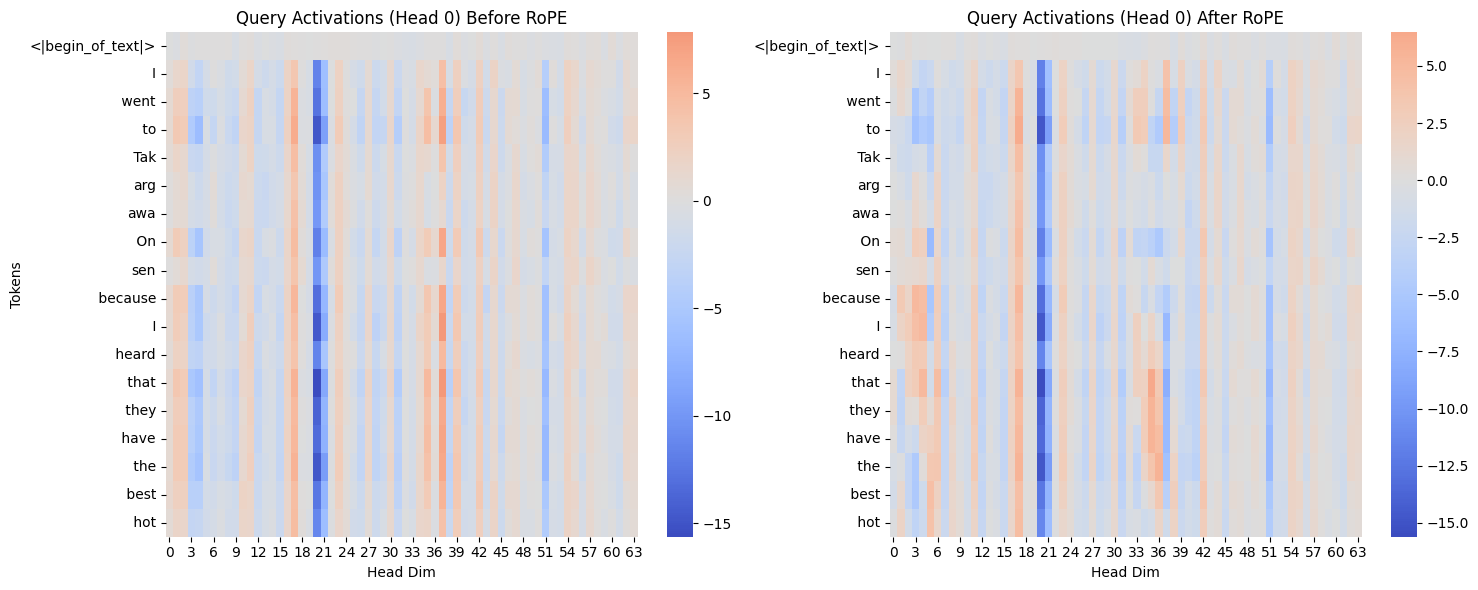

In [8]:
batch_idx = 1
head_idx = 0 # > 8 will error

# Extract post RoPE activations for a single batch and head
q_head_post = rot_act_q_cached[batch_idx, :, head_idx, :].cpu().numpy()  # Shape: (seq_len, head_dim)
q_head_pre = pre_rot_q_cached[batch_idx, :, head_idx, :].cpu().numpy() 

tokens = [model.tokenizer.decode([tok]) for tok in all_tokens[batch_idx]]

# Create a figure with two subplots (side-by-side heatmaps)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap for pre-RoPE query activations
sns.heatmap(q_head_pre, cmap="coolwarm", center=0, ax=axes[0], yticklabels=tokens)
axes[0].set_title(f"Query Activations (Head {head_idx}) Before RoPE")
axes[0].set_xlabel("Head Dim")
axes[0].set_ylabel("Tokens")

# Heatmap for post-RoPE query activations
sns.heatmap(q_head_post, cmap="coolwarm", center=0, ax=axes[1], yticklabels=tokens)
axes[1].set_title(f"Query Activations (Head {head_idx}) After RoPE")
axes[1].set_xlabel("Head Dim")
axes[1].set_ylabel("")  # Remove redundant ylabel for cleaner visualization

# Show the plot
plt.tight_layout()
plt.show()

# Animation of Pre vs. Post RoPE Query Activation reduced to 2D by PCA

In [153]:
import numpy as np
import plotly.graph_objects as go
from src.patching.utils import strip_eot
from sklearn.decomposition import PCA

seq_len, head_dim = 18, 64
# Choose a sequence index and attention head to visualize
seq_idx = 4
head_idx = 0
np.random.seed(0)

tokens_batch = all_tokens[seq_idx]
stripped_tokens = strip_eot(tokens_batch, model.tokenizer.pad_token_id)
token_names = [model.tokenizer.decode([tok]) for tok in stripped_tokens]

pre_q_head = pre_rot_q_cached[seq_idx, :, head_idx, :].cpu().numpy()
post_q_head = rot_act_q_cached[seq_idx, :, head_idx, :].cpu().numpy()  

# token_names = [f"Token {i}" for i in range(seq_len)]
n_tokens = len(token_names)

# Ensure the number of tokens matches the number of rows
pre_q_head = pre_q_head[:n_tokens]
post_q_head = post_q_head[:n_tokens]

# --------------------------
# PCA Projection
# --------------------------
# Combine pre- and post-RoPE activations along the token axis.
combined = np.concatenate([pre_q_head, post_q_head], axis=0)

# Perform PCA to reduce to 2D.
pca = PCA(n_components=2)
combined_2d = pca.fit_transform(combined)

# Split back into pre and post PCA projections.
pre_q_2d = combined_2d[:n_tokens]
post_q_2d = combined_2d[n_tokens:]

# --------------------------
# Generate Animation Frames
# --------------------------
Nframes = 50
frames = []
for frame in range(Nframes + 1):
    alpha = frame / Nframes
    # Linearly interpolate between pre- and post-PCA points.
    intermediate = (1 - alpha) * pre_q_2d + alpha * post_q_2d
    frames.append(
        go.Frame(
            data=[go.Scatter(
                x=intermediate[:, 0],
                y=intermediate[:, 1],
                mode='markers+text',
                text=token_names,
                textposition='top center',
                marker=dict(color='red', size=10),
                name='Interpolated',
                showlegend=False  # Prevent duplicate legend entries
            )],
            name=f'frame{frame}'
        )
    )

# --------------------------
# Build Base Figure
# --------------------------
fig = go.Figure(
    data=[
        # Pre-RoPE projections (blue)
        go.Scatter(
            x=pre_q_2d[:, 0],
            y=pre_q_2d[:, 1],
            mode='markers+text',
            text=token_names,
            textposition='top center',
            marker=dict(color='blue', size=10),
            name='Pre-RoPE'
        ),
        # Post-RoPE projections (green)
        go.Scatter(
            x=post_q_2d[:, 0],
            y=post_q_2d[:, 1],
            mode='markers+text',
            text=token_names,
            textposition='top center',
            marker=dict(color='green', size=10),
            name='Post-RoPE'
        ),
        # Animated/interpolated trace (red) – initially set to the pre-PCA positions.
        go.Scatter(
            x=pre_q_2d[:, 0],
            y=pre_q_2d[:, 1],
            mode='markers+text',
            text=token_names,
            textposition='top center',
            marker=dict(color='red', size=10),
            name='Interpolated'
        )
    ],
    frames=frames
)

# --------------------------
# Layout & Animation Controls
# --------------------------
# Determine axis ranges based on the combined PCA projection.
x_vals = combined_2d[:, 0]
y_vals = combined_2d[:, 1]

fig.update_layout(
    title="Animation of Pre vs. Post RoPE Query Activation reduced to 2D by PCA",
    xaxis=dict(title="PC 1", range=[x_vals.min()-1, x_vals.max()+1]),
    yaxis=dict(title="PC 2", range=[y_vals.min()-1, y_vals.max()+1]),
    updatemenus=[{
        "type": "buttons",
        "buttons": [{
            "label": "Play",
            "method": "animate",
            "args": [None, {"frame": {"duration": 100, "redraw": True},
                            "fromcurrent": True}]
        }]
    }]
)

fig.show()

# Static visualizations of pre vs post RoPE

Prompt: <|begin_of_text|>Flowers bloom in the season of


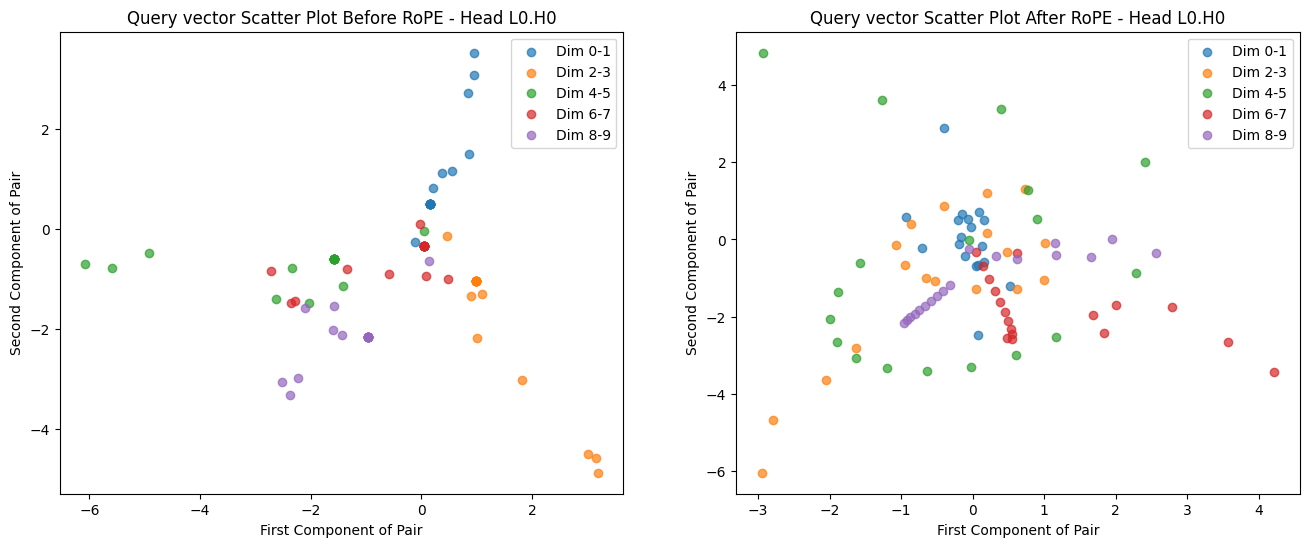

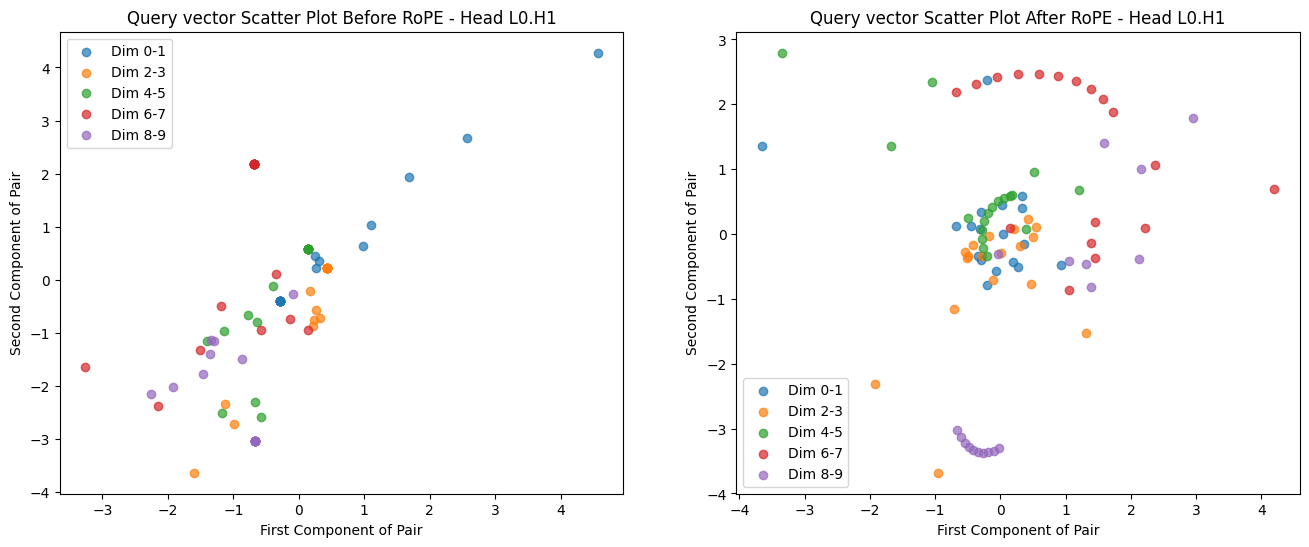

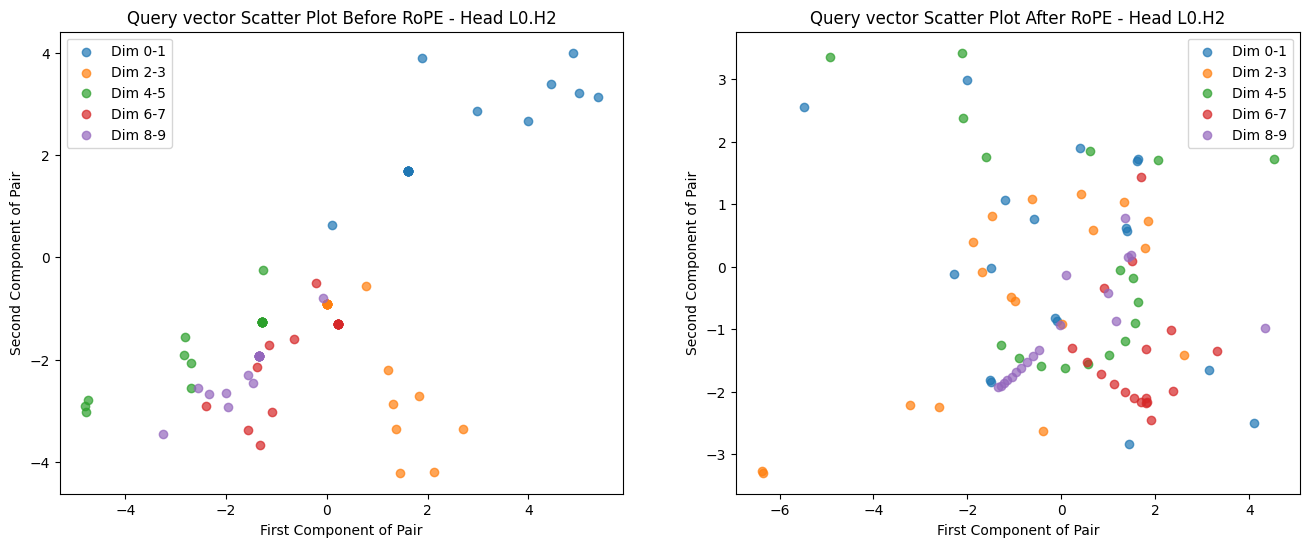

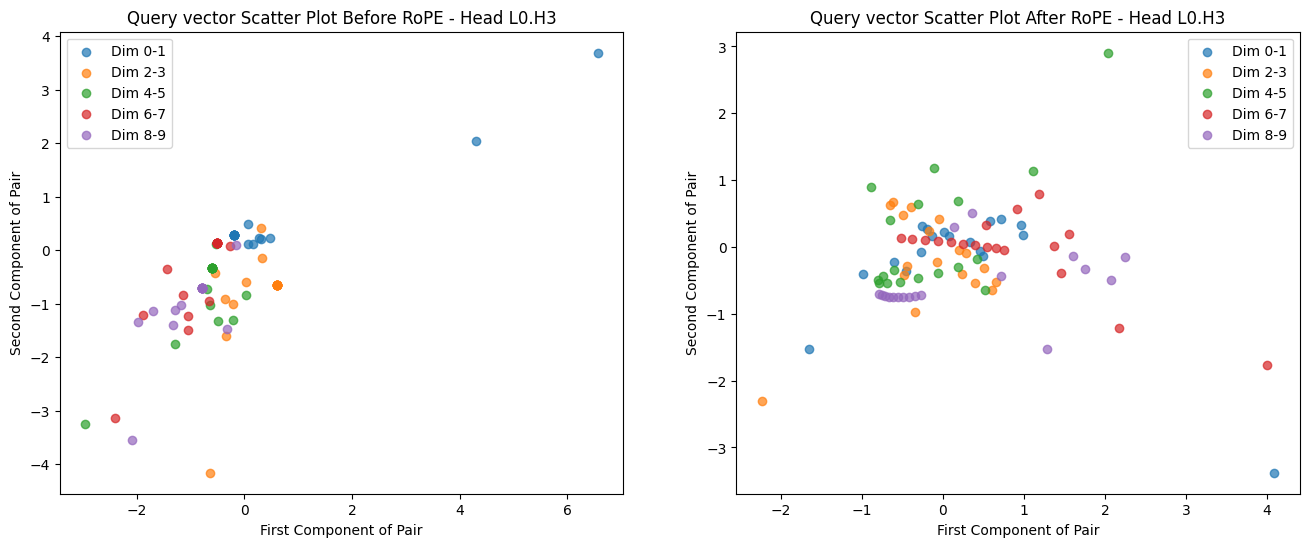

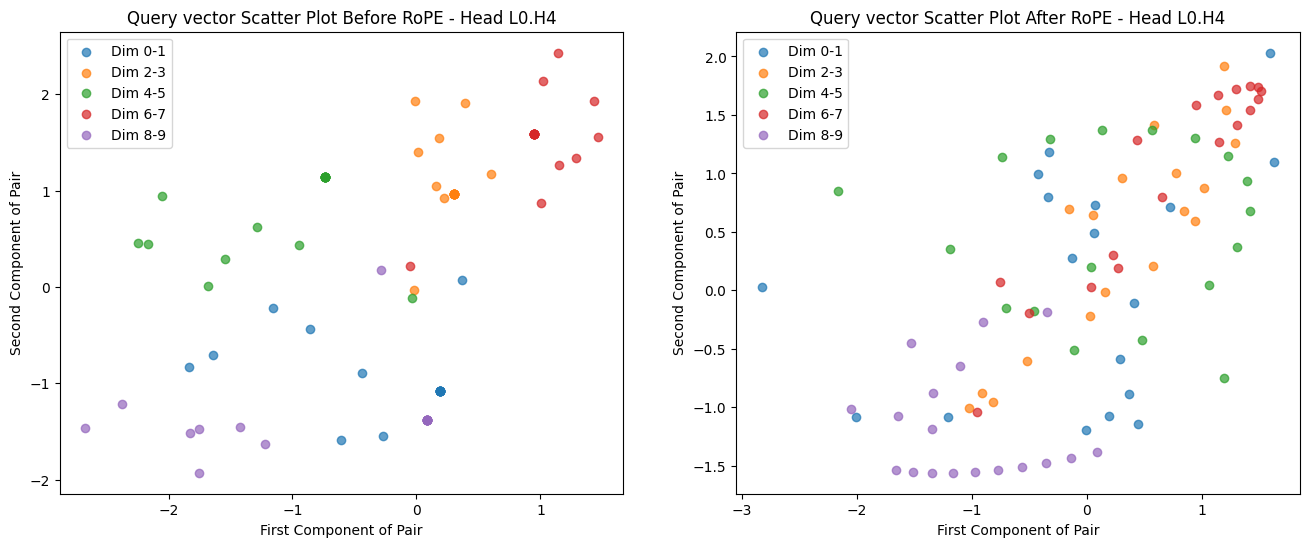

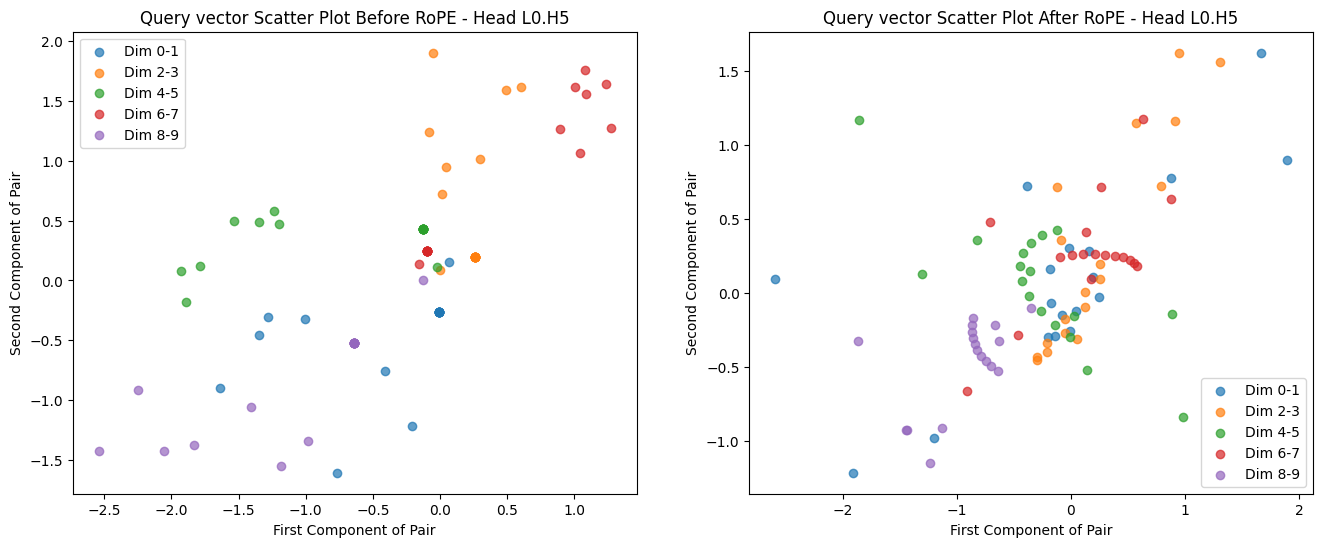

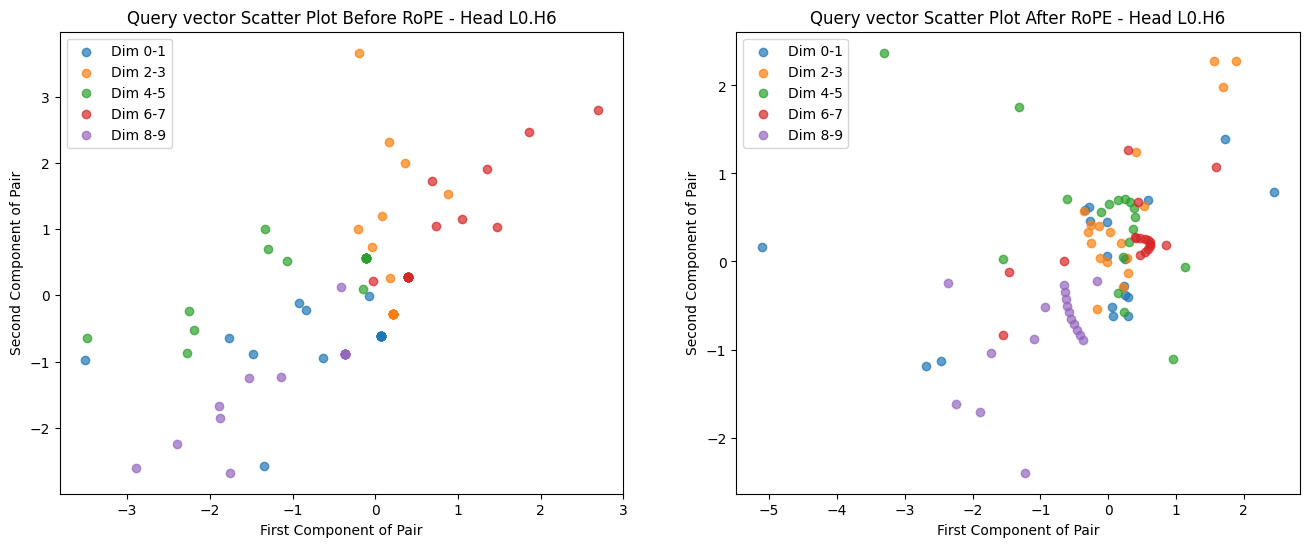

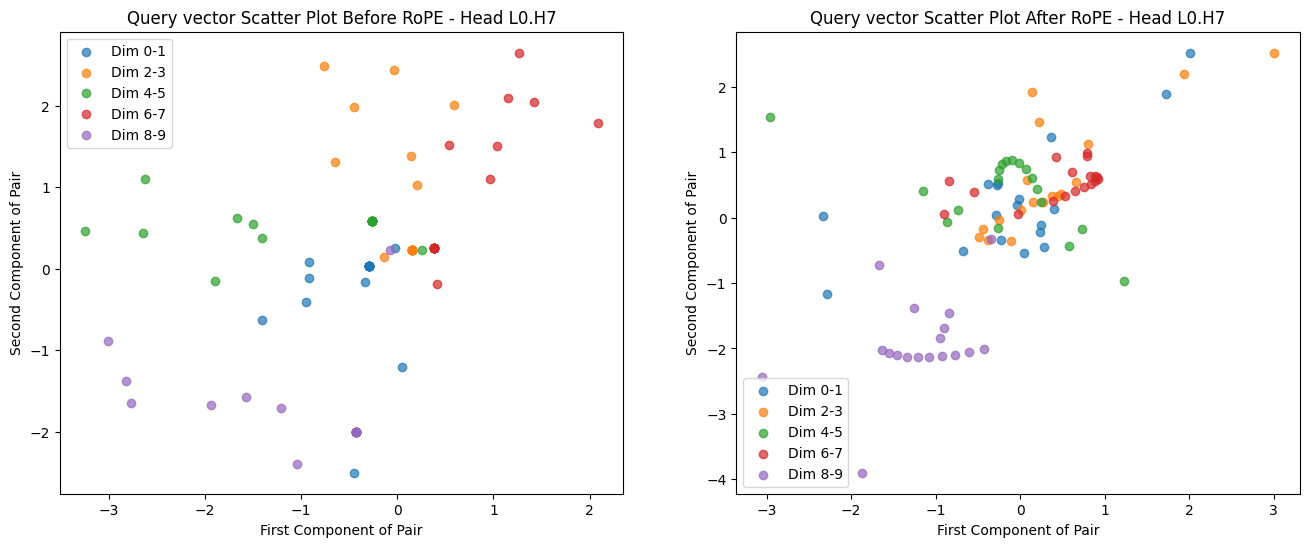

In [ ]:
from src.patching.utils import strip_eot

seq_idx = 0
head_idx = 0

stripped_tokens = strip_eot(all_tokens[seq_idx], model.tokenizer.pad_token_id)
print(f'Prompt: {model.to_string(stripped_tokens)}')

for i in range(model.cfg.n_key_value_heads):
    # Extract activations for one head at the chosen sequence index (before and after RoPE)
    pre_q_head = pre_rot_q_cached[seq_idx, :, i, :].cpu().numpy()  # Pre-RoPE (Shape: seq_len, head_dim)
    post_q_head = rot_act_q_cached[seq_idx, :, i, :].cpu().numpy() # Post-RoPE

    # Define 2D subspaces for visualization
    dim_pairs = list(range(0, q_head_post.shape[1], 2))  # Take pairs (0,1), (2,3), etc.

    # --- Side by Side Scatter Plot: Pre-RoPE and Post-RoPE Queries ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pre-RoPE Queries
    for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
        axes[0].scatter(pre_q_head[:, dim], pre_q_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
    axes[0].set_title(f"Query vector Scatter Plot Before RoPE - Head L0.H{i}")
    axes[0].set_xlabel("First Component of Pair")
    axes[0].set_ylabel("Second Component of Pair")
    axes[0].legend()

    # Post-RoPE Queries
    for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
        axes[1].scatter(post_q_head[:, dim], post_q_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
    axes[1].set_title(f"Query vector Scatter Plot After RoPE - Head L0.H{i}")
    axes[1].set_xlabel("First Component of Pair")
    axes[1].set_ylabel("Second Component of Pair")
    axes[1].legend()

    plt.show()


Prompt: <|begin_of_text|>Flowers bloom in the season of


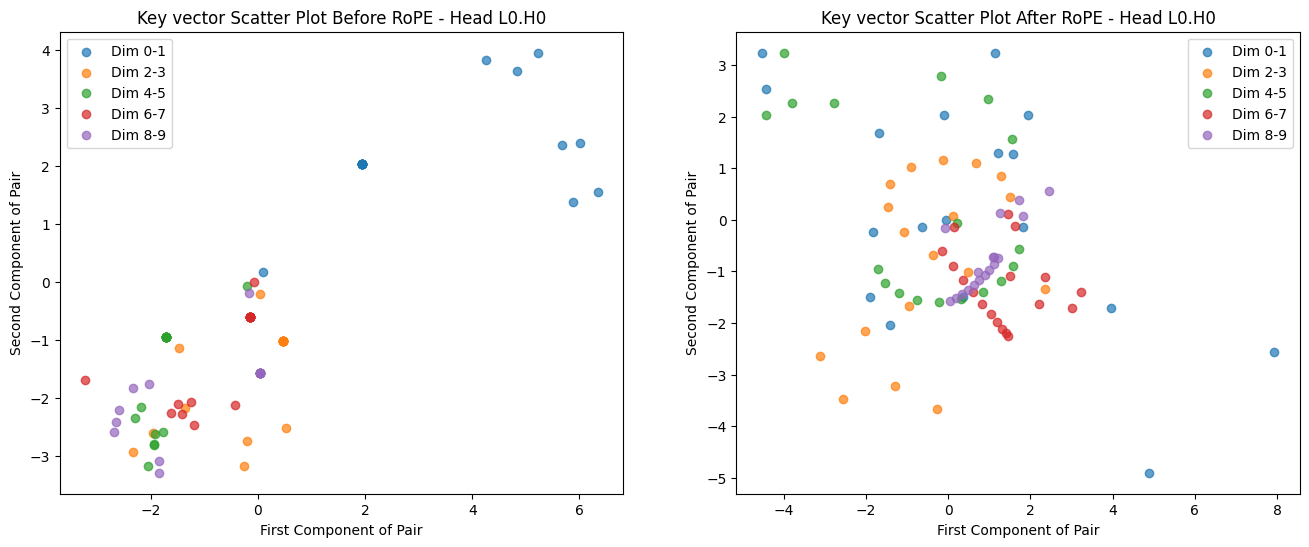

In [42]:
batch_idx = 0
head_idx = 0

stripped_tokens = strip_eot(all_tokens[seq_idx], model.tokenizer.pad_token_id)
print(f'Prompt: {model.to_string(stripped_tokens)}')

# Extract activations for one head at the chosen sequence index (before and after RoPE)
pre_k_head = pre_rot_k_cached[batch_idx, :, head_idx, :].cpu().numpy()  # Pre-RoPE (Shape: seq_len, head_dim)
post_k_head = rot_act_k_cached[batch_idx, :, head_idx, :].cpu().numpy()  

# Define 2D subspaces for visualization
dim_pairs = list(range(0, q_head_post.shape[1], 2))  # Take pairs (0,1), (2,3), etc.

# --- Side by Side Scatter Plot: Pre-RoPE and Post-RoPE Queries ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pre-RoPE Queries
for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
    axes[0].scatter(pre_k_head[:, dim], pre_k_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
axes[0].set_title(f"Key vector Scatter Plot Before RoPE - Head L0.H{head_idx}")
axes[0].set_xlabel("First Component of Pair")
axes[0].set_ylabel("Second Component of Pair")
axes[0].legend()

# Post-RoPE Queries
for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
    axes[1].scatter(post_k_head[:, dim], post_k_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
axes[1].set_title(f"Key vector Scatter Plot After RoPE - Head L0.H{head_idx}")
axes[1].set_xlabel("First Component of Pair")
axes[1].set_ylabel("Second Component of Pair")
axes[1].legend()

plt.show()

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 8 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=0.75 for 250 iterations...
Iteration   50, KL divergence -0.5155, 50 iterations in 0.0064 sec
Iteration  100, KL divergence 0.1178, 50 iterations in 0.0030 sec
Iteration  150, KL divergence 0.1178, 50 iterations in 0.0027 sec
Iteration  200, KL divergence 0.1178, 50 iterations in 0.0024 sec
Iteration  250, KL divergence 0.1178, 50 iterations in 0.0024 sec
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=1.00, lr=9.00 for 500 iter

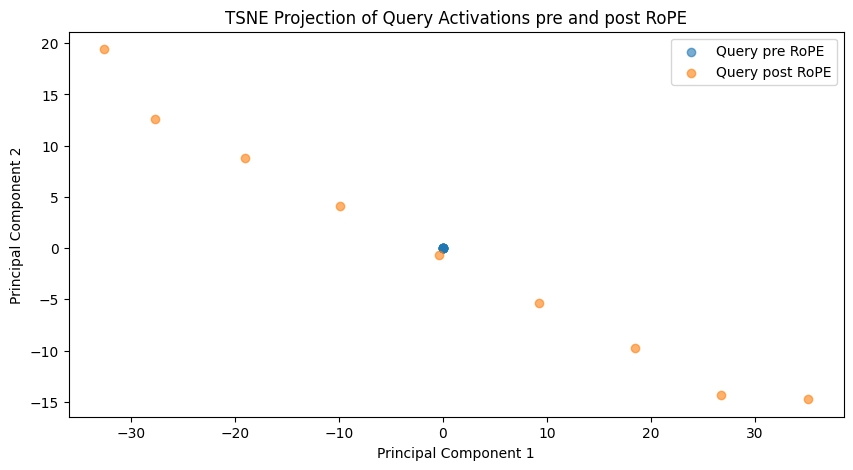

In [154]:
# openTSNE, faster implementation of TSNE with Davies-Bouldin approximation: https://opentsne.readthedocs.io/en/stable/examples/01_simple_usage/01_simple_usage.html
from openTSNE import TSNE 

tsne1 = TSNE(n_components=2, random_state=42, verbose=True)
tsne2 = TSNE(n_components=2, random_state=42, verbose=True)
q_pre_pca = tsne1.fit(pre_q_head)
q_post_pca = tsne2.fit(post_q_head)

plt.figure(figsize=(10, 5))
plt.scatter(q_pre_pca[:, 0], q_pre_pca[:, 1], alpha=0.6, label="Query pre RoPE")
plt.scatter(q_post_pca[:, 0], q_post_pca[:, 1], alpha=0.6, label="Query post RoPE")
plt.title("TSNE Projection of Query Activations pre and post RoPE")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# GQA Attention

<details><summary>Technical implementation details of GQA</summary>

From `transformer_lens.components.grouped_query_attention` docstring:

Similar to regular attention, W_Q, W_K, and W_V all have shape `[head_index, d_model, d_head]`.
However, under the hood the key and value weights _W_K and _W_V are stored with shape `[n_key_value_heads, d_model, d_head]` and are expanded when the corresponding properties' getter is called.
Similarly, during a forward pass, initially K and V are kept in shapes `[batch, pos, n_key_value_heads, d_head]` and *will only be expanded to shapes* `[batch, pos, n_heads, d_head]` using `torch.repeat_interleave` **when the attention pattern (post-softmax) and z-scores (attention patterns weighted by value) are calculated**: 

attention scores QK dot-product: 

```
k = torch.repeat_interleave(k, dim=2, repeats=self.repeat_kv_heads)
return qk # pattern
```

z-scores (QKV): 
```
v = torch.repeat_interleave(v, dim=2, repeats=self.repeat_kv_heads)
return v * pattern 
```

Example for `torch.repeat_interleave`: 

```
x = torch.tensor([1, 2, 3])
x.repeat_interleave(2)
>>> tensor([1, 1, 2, 2, 3, 3])

y = torch.tensor([[1, 2], [3, 4]])
torch.repeat_interleave(y, 2)
>>> tensor([1, 1, 2, 2, 3, 3, 4, 4])

torch.repeat_interleave(y, 3, dim=1)
torch.repeat_interleave(y, torch.tensor([1, 2]), dim=0)
>>> tensor([[1, 1, 1, 2, 2, 2],
        [3, 3, 3, 4, 4, 4]])

torch.repeat_interleave(y, torch.tensor([1, 2]), dim=0, output_size=3)
>>> tensor([[1, 2],
        [3, 4],
        [3, 4]])

```

</details> 

In [ ]:
from src.observational.utils import show_attention_patterns
import re

all_heads = model.all_head_labels()
heads_to_visualize = all_heads[:model.cfg.n_heads] # all heads from layer 0
print("Heads to visualize:", heads_to_visualize)

parsed_heads = []
pattern = re.compile(r"^L(\d+)H(\d+)$")
for head_str in heads_to_visualize:
    match = pattern.match(head_str)
    if match:
        layer = int(match.group(1))
        head = int(match.group(2))
        parsed_heads.append((layer, head))

show_attention_patterns(model, parsed_heads, prompts=all_prompts_strings[batch_idx], mode="scores")

Heads to visualize: ['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4', 'L0H5', 'L0H6', 'L0H7', 'L0H8', 'L0H9', 'L0H10', 'L0H11', 'L0H12', 'L0H13', 'L0H14', 'L0H15', 'L0H16', 'L0H17', 'L0H18', 'L0H19', 'L0H20', 'L0H21', 'L0H22', 'L0H23', 'L0H24', 'L0H25', 'L0H26', 'L0H27', 'L0H28', 'L0H29', 'L0H30', 'L0H31']
